Notebook correspondant à la section 4.1.2 du rapport, pour la résolution des équations sur $M_x$ et $M_y$ couplées de la précession amortie :
\begin{equation}
\left\{
    \begin{aligned}
        \frac{dM_x}{d\tilde{t}} &= - M_y\omega_z - \lambda M_x M_z \omega_z \\
        \frac{dM_y}{d\tilde{t}} &= M_x\omega_z - \lambda M_y M_z \omega_z
    \end{aligned}
\right.
\end{equation}

In [80]:
#imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Physical parameters

In [81]:
#initial value for M = [Mx, My] vector
M_0 = tf.constant([1,0], dtype='float32') 
#initial value for Mz
M_z0 = tf.constant(0, dtype='float32') 
W = 2*np.pi
lamb = -0.3

Definition of the ODE

In [82]:
def ODE(Mx, My, Mz, W, lamb) :
    dMx = -W*(My + lamb*tf.multiply(Mx,Mz_tensor))
    dMy = W*(Mx - lamb*tf.multiply(My,Mz_tensor))
    return dMx, dMy

Training parameters

In [83]:
N = 40 #number of samples for the independant variable
t_a = -1
t_b = 1
training_points = np.linspace(t_a,t_b,N)
training_points = tf.convert_to_tensor(training_points, dtype=tf.float32)

load_model = False
load_filename = "models/Mx_My"
save_model = False
save_filename = "models/Mx_My"


Load the model for the evolution of Mz

In [84]:
Mz_model_filename = "models/Mz_NN"
Mz_model = tf.keras.models.load_model(Mz_model_filename)
Mz_NN = Mz_model(training_points)

Mz_tensor = M_z0+training_points*Mz_NN[:,0]

Initializing the network

In [85]:
# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 16 # 1st layer number of neurons
n_output = 2    # output layer number of neurons

#model definition :
model = tf.keras.Sequential([
  tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.sigmoid, input_shape=(n_input,)),  
  tf.keras.layers.Dense(n_output)
])

if load_model :
    model = tf.keras.models.load_model(load_filename)



Loss function
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape


In [86]:
def loss_function(model, input_tensor, M_0, lamb, Mz_tensor):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_tensor)
        output = model(input_tensor)
        Mx, My = M_0[0]+input_tensor*output[:,0], M_0[1]+input_tensor*output[:,1]

    dMx = tape.gradient(Mx, input_tensor)
    dMy = tape.gradient(My, input_tensor)

    dMx_target, dMy_target = ODE(Mx, My, Mz_tensor, W, lamb)

    ex = dMx - dMx_target
    ey = dMy - dMy_target

    return tf.reduce_mean(ex**2 + ey**2)

Gradient of loss

In [87]:
def grad(model, input_tensor, M_0, lamb, Mz_tensor):
    with tf.GradientTape() as tape:
        loss_value = loss_function(model, input_tensor, M_0, lamb, Mz_tensor)

    gradient = tape.gradient(loss_value, model.trainable_variables)

    return loss_value, gradient

Training the neural network

In [106]:
learning_rate = 3e-3
epochs = 2000
display_step = min(max(1,epochs//100), 1000)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

In [107]:
losses = []
epochs_displayed = []

for epoch in range(epochs) :
    loss_value, grads = grad(model, training_points, M_0, lamb, Mz_tensor)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % display_step == 0 :
        print("Loss after",epoch,"/",epochs,"epochs :",loss_value.numpy())
        losses.append(loss_value.numpy())
        epochs_displayed.append(epoch)

loss_value, grads = grad(model, training_points, M_0, lamb, Mz_tensor)
print("Final loss after",epochs,"epochs :",loss_value.numpy())
losses.append(loss_value.numpy())
epochs_displayed.append(epochs)

Loss after 0 / 2000 epochs : 0.5539762
Loss after 20 / 2000 epochs : 0.55358636
Loss after 40 / 2000 epochs : 0.55319726
Loss after 60 / 2000 epochs : 0.5528089
Loss after 80 / 2000 epochs : 0.55242044
Loss after 100 / 2000 epochs : 0.55203336
Loss after 120 / 2000 epochs : 0.55164826
Loss after 140 / 2000 epochs : 0.55126154
Loss after 160 / 2000 epochs : 0.550877
Loss after 180 / 2000 epochs : 0.55049247
Loss after 200 / 2000 epochs : 0.55010974
Loss after 220 / 2000 epochs : 0.5497266
Loss after 240 / 2000 epochs : 0.5493456
Loss after 260 / 2000 epochs : 0.54896367
Loss after 280 / 2000 epochs : 0.5485834
Loss after 300 / 2000 epochs : 0.5482032
Loss after 320 / 2000 epochs : 0.5478238
Loss after 340 / 2000 epochs : 0.5474452
Loss after 360 / 2000 epochs : 0.54706705
Loss after 380 / 2000 epochs : 0.54668975
Loss after 400 / 2000 epochs : 0.5463128
Loss after 420 / 2000 epochs : 0.54593647
Loss after 440 / 2000 epochs : 0.5455612
Loss after 460 / 2000 epochs : 0.5451873
Loss after 

In [90]:
if save_model :
    model.save(save_filename)

Plot the evolution of loss

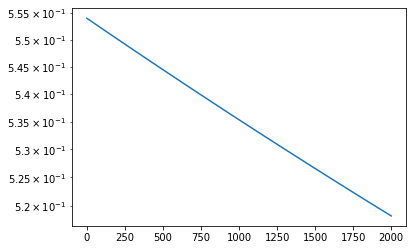

In [108]:
plt.plot(epochs_displayed, losses)
plt.yscale('log')
plt.show()


Compute the analytic solution

In [92]:
plotting_points = np.linspace(t_a,t_b,200)
plotting_points = tf.convert_to_tensor(plotting_points, dtype=tf.float32)


#for plotting_points
K = (M_z0-1) / (M_z0+1)
exp_vector = tf.exp(-lamb*W*plotting_points)
F = exp_vector*(K-1)/(K*exp_vector**2-1)

Mx_ana =tf.multiply( F,(  tf.cos(W*plotting_points)*M_0[0] - tf.sin(W*plotting_points)*M_0[1]))
My_ana = tf.multiply(F,( tf.sin(W*plotting_points)*M_0[0] + tf.cos(W*plotting_points)*M_0[1]))

#for training_points
K = (M_z0-1) / (M_z0+1)
exp_vector = tf.exp(-lamb*W*training_points)
F = exp_vector*(K-1)/(K*exp_vector**2-1)

Mx_training =tf.multiply( F,(  tf.cos(W*training_points)*M_0[0] - tf.sin(W*training_points)*M_0[1]))
My_training = tf.multiply(F,( tf.sin(W*training_points)*M_0[0] + tf.cos(W*training_points)*M_0[1]))



Plot the estimation and the analytic solution

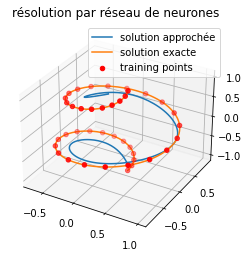

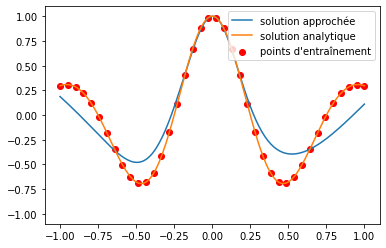

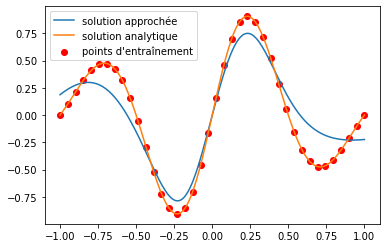

In [109]:
#neural network estimation
output = model(plotting_points)
Mx_NN, My_NN = M_0[0]+plotting_points*output[:,0], M_0[1]+plotting_points*output[:,1]


#3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(        xs=Mx_NN,
                ys=My_NN,
                zs=plotting_points,
                label='solution approchée')

ax.plot(        xs=Mx_ana,
                ys=My_ana,
                zs=plotting_points,
                label='solution exacte')



ax.scatter(     xs=Mx_training,
                ys=My_training,
                zs=training_points,
                color='red',
                label='training points')

plt.legend()
plt.title('résolution par réseau de neurones')
plt.show()

plt.plot(plotting_points, Mx_NN, label='solution approchée')
plt.plot(plotting_points, Mx_ana, label='solution analytique')
plt.scatter(training_points, Mx_training,color='red', label="points d'entraînement")
plt.ylim(-1.1, 1.1)
plt.legend()
plt.show()
plt.plot(plotting_points, My_NN, label='solution approchée')
plt.plot(plotting_points, My_ana, label='solution analytique')
plt.scatter(training_points, My_training,color='red', label="points d'entraînement")
plt.legend()
plt.show()

We can check if the norm of the magnetization found is conserved :

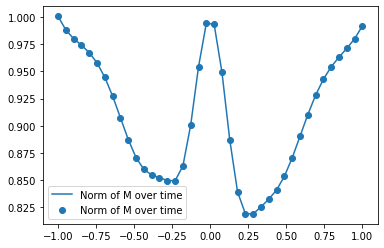

In [97]:
#neural network estimation
output = model(training_points)
Mx_NN, My_NN = M_0[0]+training_points*output[:,0], M_0[1]+training_points*output[:,1]
norm = tf.sqrt(Mx_NN**2 + My_NN**2 + Mz_tensor**2)

plt.plot(training_points, norm, label='Norm of M over time')
plt.scatter(training_points, norm, label='Norm of M over time')
plt.legend()
plt.show()